# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

import matplotlib.pyplot as plt 

import numpy as np

import seaborn as sns

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep= '\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep= '\t')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
def review_df(df):
    print(df.head())
    print(df.describe())
    print(df.info())
    print(df.duplicated().sum())
    
review_df(data)

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт

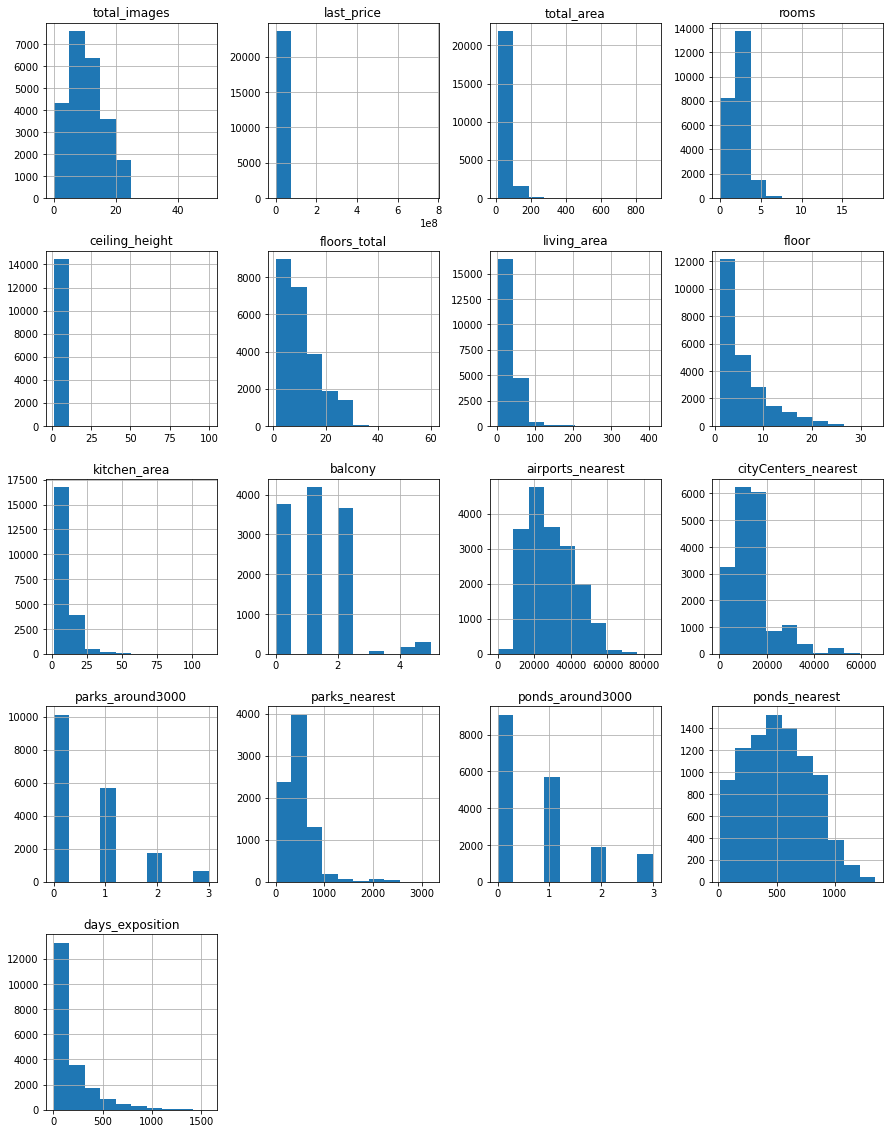

In [5]:
data.hist(figsize=(15, 20));


<div style="border:solid green 2px; padding: 20px">
    
При первом знакомстве с данными обращаем внимание на:

1. Столбец `total_images` не понадобится для анализа, так как скорее всего это количество изображений недвижимости. 

2. В столбце `is_apartment` тип данных object, хотя скорее всего должен быть bool(объект недвижимости - апартаменты(True)). Однако этот столбец нам не понадобится для дальнейшего анализа.

3. Есть столбцы с большим количеством пропусков скорее всего обусловлен отсутствием данного критерия( `balcony`, `parks_around3000`, и другие). 

4. На диаграмме с данными о высоте потолков `ceiling_height` часть данных в пределах 25 метров. 

5. `floors_total` имеет максимальное значение 60. Однако в Ленинградской области самое больше жилое здание имеет 35 этажей. 

6. Есть объекты, где значение столбца - 0. В `rooms` скорее всего это студии, или объекты `open_plan`. `airports_nearest` вероятно объекты находятся в области.

5. Столбец `first_day_exposition` имеет тип данных object, а не datetime.

6. Есть столбцы с типом данных float, но их следует перевест в тип данных int(`floors_total`, `days_exposition` )

#### Выводы

<div style="border:solid green 2px; padding: 20px">
Перед анализом данных проведем предобработку данных в тех столбцах, которые понадобятся. Исключим аномальные значения и пропуски, поменяем тип данных.

### Предобработка данных

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


<div style="border:solid green 2px; padding: 20px">
Уберём те столбцы, которые не понадобятся для анализа.

In [7]:
data.drop(columns = ['total_images', 'is_apartment', 'ponds_nearest', 'ponds_around3000',\
          'parks_around3000', 'balcony'], axis = 1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_price            23699 non-null  float64
 1   total_area            23699 non-null  float64
 2   first_day_exposition  23699 non-null  object 
 3   rooms                 23699 non-null  int64  
 4   ceiling_height        14504 non-null  float64
 5   floors_total          23613 non-null  float64
 6   living_area           21796 non-null  float64
 7   floor                 23699 non-null  int64  
 8   studio                23699 non-null  bool   
 9   open_plan             23699 non-null  bool   
 10  kitchen_area          21421 non-null  float64
 11  locality_name         23650 non-null  object 
 12  airports_nearest      18157 non-null  float64
 13  cityCenters_nearest   18180 non-null  float64
 14  parks_nearest         8079 non-null   float64
 15  days_exposition    

In [8]:
data.isna().sum()

last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
studio                      0
open_plan                   0
kitchen_area             2278
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_nearest           15620
days_exposition          3181
dtype: int64


<div style="border:solid green 2px; padding: 20px">
Столбец с данными о высоте потолов имеет аномальные значения, значения свыше 20 и менее 2 метров, пропуски. 

In [9]:
#Заменим аномальные значения в столбце `ceiling_height`.
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 20, data['ceiling_height']/10)

In [10]:
good_ceiling = data.query('2 <= ceiling_height <= 6')
good_ceiling['ceiling_height'].median()

2.65

In [11]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.65)
data = data.query('2 <= ceiling_height <= 6')


<div style="border:solid green 2px; padding: 20px">
Уберём строки с небольшим процентом пропусков.

In [12]:
data = data.dropna(subset = ['floors_total'])
data = data.dropna(subset = ['locality_name'])


<div style="border:solid green 2px; padding: 20px">
Столбцы `floors_total` и `last_price` имеют тип данных float вместо int. А также аномальные значения.

In [13]:
data = data.astype({ "floors_total": "int64", "last_price": "int64"})


<div style="border:solid green 2px; padding: 20px">
60 этажей скорее всего опечатка, заменим на 60. Так как выше 35 этажа жилых зданий в городе нет, то заменяем все значения выше 35 на 35. Тем более все эти объекты одинаково удалены от аэропорта, и подходят под локацию самого высокого здания.

In [14]:
data['floors_total'] = data['floors_total'].where(data['floors_total'] < 60, 6)
data['floors_total'] = data['floors_total'].where(data['floors_total'] <= 35, 35)

In [15]:
data = data.query('(last_price>300000) and (last_price<40000000)')


<div style="border:solid green 2px; padding: 20px">
В столбце `days_exposition` пропущенных данных много(свыше 10%), мы не можем удалить их. Оставим их и переведем тип данных в int.

In [16]:
data['days_exposition'] = data['days_exposition'].fillna(0)


<div style="border:solid green 2px; padding: 20px">
Столбец `first_day_exposition` приведём к типу datetime.

In [17]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])


<div style="border:solid green 2px; padding: 20px">
Теперь проведем поиск неявных дубликатов в названиях населенных пунктах.

In [18]:
data['locality_name'] = data['locality_name'].str.replace(r'^(поселок) ','посёлок ', regex=True)
data['locality_name'] = data['locality_name'].str.replace(r'^(посёлок Сапёрное)','посёлок Сапёрный', regex=True)
data['locality_name'] = data['locality_name'].str.replace(r'^(деревня Кудрово)','Кудрово', regex=True)


<div style="border:solid green 2px; padding: 20px">
В столбцах `airports_nearest`, `cityCenters_nearest` заполним медианным значением по населённым пунктам, где это возможно. Остальные пропуски в `cityCenters_nearest` заменим на 0. Скорее всего продавец не заполнял эти графы. Либо нет парков и аэропортов рядом, либо объект недвижимости слишком удален от центра, либо не расположен в Санкт-Петербурге вовсе. Столбец с информацией о парках пропуски оставим. Их слишком много, а адекватно заполнить их нельзя.

In [19]:
data['cityCenters_nearest'] = np.floor(pd.to_numeric(data['cityCenters_nearest'], errors='coerce')).astype('Int64')


<div style="border:solid green 2px; padding: 20px">
193 объекта со значением 0. Скорее всего это квартиры студии и открытого плана. 

In [20]:
data.query('(rooms==0) and ((studio==True) or (open_plan == True))').describe()

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,airports_nearest,cityCenters_nearest,parks_nearest,days_exposition
count,1.930000e+02,193.000000,193.0,193.000000,193.000000,183.000000,193.000000,0.0,116.000000,116.000000,27.000000,193.000000
mean,2.993946e+06,27.551347,0.0,2.712332,16.948187,18.865246,8.549223,NaN,24525.405172,13467.051724,579.814815,102.424870
std,1.422128e+06,8.426054,0.0,0.254493,6.906927,6.549527,6.325289,NaN,12492.919854,5022.435743,308.608544,157.017567
min,9.457500e+05,15.500000,0.0,2.500000,3.000000,2.000000,1.000000,NaN,6989.000000,1261.000000,38.000000,0.000000
25%,2.300000e+06,24.050000,0.0,2.650000,12.000000,16.000000,3.000000,NaN,14247.000000,11663.000000,389.500000,20.000000
50%,2.700000e+06,26.050000,0.0,2.650000,17.000000,18.000000,7.000000,NaN,21131.000000,13672.000000,529.000000,45.000000
75%,3.380000e+06,28.300000,0.0,2.700000,23.000000,19.950000,13.000000,NaN,34201.000000,16481.750000,756.000000,115.000000
max,1.630000e+07,98.400000,0.0,5.800000,35.000000,68.000000,26.000000,NaN,55551.000000,29846.000000,1199.000000,931.000000



<div style="border:solid green 2px; padding: 20px">
Предположение оказалось верным. Заменим значения 0 на 1. Так как по жилищному кодексу, это всё считается однокомнатной квартирой. 

In [21]:
data['rooms'] = data['rooms'].where(data['rooms'] !=0, 1)

### Посчитайте и добавьте в таблицу новые столбцы

#### Цена одного квадратного метра.

In [22]:
data['price_sq_met'] = data['last_price']/data['total_area']
data['price_sq_met'] = data['price_sq_met'].astype('int64')

#### День недели публикации объявления (0 — понедельник, 1 — вторник и так далее).

In [23]:
data['week_day'] = data['first_day_exposition'].dt.weekday

#### Месяц публикации объявления.

In [24]:
data['month'] = data['first_day_exposition'].dt.month

#### Год публикации объявления.

In [25]:
data['year'] = data['first_day_exposition'].dt.year

#### Тип этажа квартиры (значения — «первый», «последний», «другой»).

In [26]:
def type_floor(kind):
    floor = kind['floor']
    floors_total = kind['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

data['type_floor'] = data.apply(type_floor, axis = 1)

#### Расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [27]:
data['distance_downtown'] = data['cityCenters_nearest']/1000
data['distance_downtown'] = data['distance_downtown'].fillna(0).astype('int64')

#### Промежуточный итог.


<div style="border:solid green 2px; padding: 20px">
Выполнены следующие этапы предобработки данных:

- Удалены столбцы, которые не понадобятся для анализа: 'total_images', 'is_apartment', 'ponds_nearest', 'ponds_around3000', 'parks_around3000', 'balcony'.


- Исправлены аномальные значения высоты потолков, заменены пропуски медианой.


- Удалены строки с небольшим процентом пропусков в столбцах 'floors_total' и 'locality_name'.


- Столбцы 'floors_total' и 'last_price' были изменены на тип integer. Аномалию в столбце 'floors_total', где значения выше 35 были заменены на 35.


- В столбце 'days_exposition' с пропущенными данными (свыше 10%) пропуски были оставлены и переведены в тип данных int.


- Столбец 'first_day_exposition' был приведен к типу datetime.


- Проведен поиск неявных дубликатов в названиях населенных пунктов.


- В столбцах 'airports_nearest' и 'cityCenters_nearest' были заполнены пропуски медианными значениями по населенным пунктам, где это возможно. Остальные пропуски в 'cityCenters_nearest' были заменены на 0, предполагая, что это связано с тем, что объект недвижимости находится далеко от центра, либо находится за пределами Санкт-Петербурга. Пропуски в столбце с информацией о парках оставлены без изменений.


- Значения 0 в столбце 'rooms' были заменены на 1, предполагая, что это квартиры студии и открытого плана.


- Добавлены новые признаки: цена одного квадратного метра, день недели публикации объявления, месяц публикации объявления, год публикации объявления и тип этажа квартиры.


- По итогам предобработки данных можно сказать, что данные были очищены от аномалий и пропусков, а также были добавлены новые признаки, которые могут быть полезными для анализа и построения модели. Данные готовы для дальнейшего анализа и построения модели для определения влияния различных факторов на цену недвижимости.

### Проведите исследовательский анализ данных


<div style="border:solid green 2px; padding: 20px">
В Санкт-Петербурге много объектов недвижимости старого фонда. Это значит, что могут присутствовать объекты нетипичные для многих других городов: большая общая площадь и более 10 комнат(коммунальные квартиры), свыше 3 метров потолки("сталинки", пентхаусы и прочее).

#### Изучение параметров объекта.

In [28]:
data.describe()

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,airports_nearest,cityCenters_nearest,parks_nearest,days_exposition,price_sq_met,week_day,month,year,distance_downtown
count,2.336100e+04,23361.000000,23361.000000,23361.000000,23361.000000,21518.000000,23361.000000,21164.000000,17846.000000,17866.000000,7876.000000,23361.000000,23361.000000,23361.000000,23361.000000,23361.000000,23361.000000
mean,5.891814e+06,58.855024,2.059758,2.693030,10.698557,33.689250,5.883310,10.388292,28822.419086,14291.712974,492.663789,155.619965,97085.975258,2.567099,6.400839,2017.375412,10.550533
std,4.552724e+06,29.907187,1.035967,0.211351,6.594256,19.276108,4.880603,5.302588,12688.742541,8600.370135,342.136195,212.677308,38017.267953,1.788245,3.492841,1.034045,9.531191
min,4.300000e+05,12.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.300000,0.000000,181.000000,1.000000,0.000000,7962.000000,0.000000,1.000000,2014.000000,0.000000
25%,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,18498.000000,9436.000000,288.000000,22.000000,76351.000000,1.000000,3.000000,2017.000000,2.000000
50%,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,26786.000000,13161.000000,456.000000,73.000000,94736.000000,3.000000,6.000000,2017.000000,11.000000
75%,6.700000e+06,69.000000,3.000000,2.700000,16.000000,42.000000,8.000000,12.000000,37407.000000,16318.750000,613.000000,197.000000,113564.000000,4.000000,10.000000,2018.000000,15.000000
max,3.999000e+07,470.300000,19.000000,5.800000,35.000000,279.600000,33.000000,100.700000,84869.000000,65968.000000,3190.000000,1580.000000,848484.000000,6.000000,12.000000,2019.000000,65.000000


##### Общая площадь.

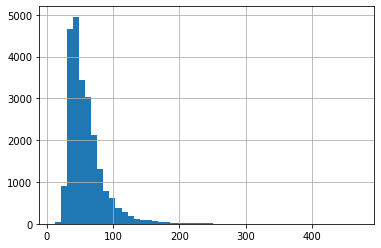

In [29]:
data['total_area'].hist(bins=50);

<div style="border:solid green 2px; padding: 20px">
Значения свыше 400 кв.м. для Санкт-Петербурга могут быть коммунальными квартирами. При этом распределение нормальное. Большинство квартир находятся в диапазоне от 40 до 69 кв.м. 

##### Жилая площадь.

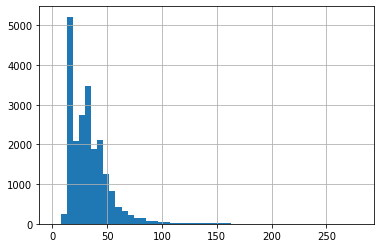

In [30]:
data['living_area'].hist(bins=50);

<div style="border:solid green 2px; padding: 20px">
Распределение нормальное, большинство объектов имеют жилую площадь в пределах от 18.6 до 42 кв.м.

##### Площадь кухни.

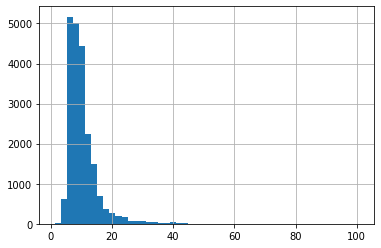

In [31]:
data['kitchen_area'].hist(bins=50);

<div style="border:solid green 2px; padding: 20px">
Распределение нормальное, большинство объектов имеют площадь кухни в пределах от 7 до 12 кв.м.

##### Цена объекта.

In [32]:
data['last_price'].describe().astype('int64')

count       23361
mean      5891814
std       4552723
min        430000
25%       3400000
50%       4600000
75%       6700000
max      39990000
Name: last_price, dtype: int64

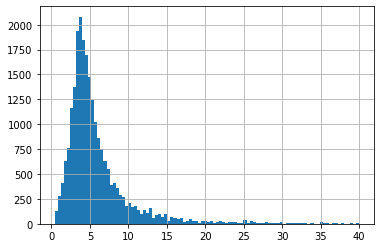

In [33]:
data['last_price'] = data['last_price']/1000000
data['last_price'].hist(bins = 100, range = (0.43, 40));

<div style="border:solid green 2px; padding: 20px">
Распределение нормальное, большинство объектов расположились в диапазоне от 3,4 млн до 6,7 млн.

##### Количество комнат.

1     8190
2     7881
3     5723
4     1128
5      285
6       88
7       43
8        9
9        6
10       2
11       2
14       2
16       1
19       1
Name: rooms, dtype: int64

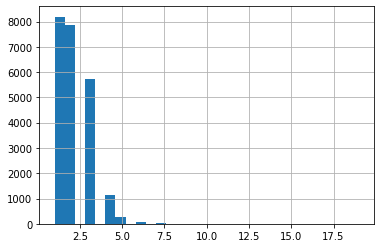

In [34]:
data['rooms'].hist(bins=30);
data['rooms'].value_counts().sort_values(ascending = False)

<div style="border:solid green 2px; padding: 20px">
Распределение нормальное, больше всего 1 или 2-х комнатных квартир.

##### Высота потолков.

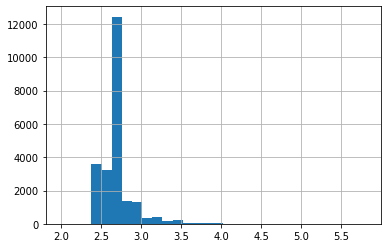

In [35]:
data['ceiling_height'].hist(bins=30);

<div style="border:solid green 2px; padding: 20px">
Распределение нормальное, высота потолков находится в диапазоне от 2,6 до 2,7 м.

##### Этаж квартиры.

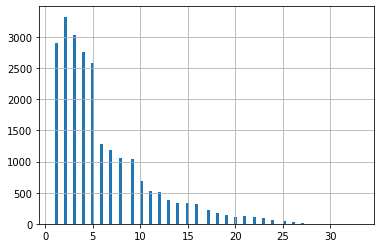

In [36]:
data['floor'].hist(bins=100);

 <div style="border:solid green 2px; padding: 20px">
Распределение нормальное. Этаж объекта находится в пределах от 2 до 8 этажа.

##### Тип этажа квартиры («первый», «последний», «другой»).

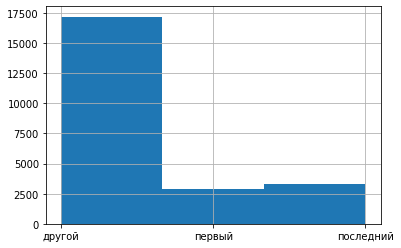

In [37]:
data['type_floor'].hist(bins=3);

<div style="border:solid green 2px; padding: 20px">
Данная диаграмма подтверждает, что тип этажа не первый и не последний превалирует.

##### Общее количество этажей в доме.

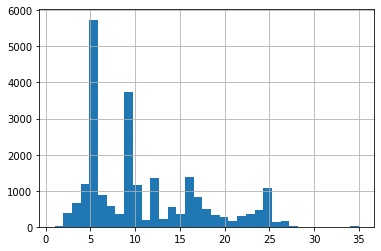

In [38]:
data['floors_total'].hist(bins=35);

<div style="border:solid green 2px; padding: 20px">
Пики находятся в объектах с 5 и 9 этажами. Последний пик 25 этажей. Это может быть связанно с тем, что:

1. В советсткое время чаще строили 5 и 9 этажные здания. Постройки до пятого этажа не требуют установки лифта, свыше девяти этажей строения должны иметь два лифта и противопожарную лестницу. 

2. В Санкт-Петербурге и ближайших районах есть запрет на постройку высоких зданий в исторических районах и центре. 

3. Для зданий свыше 25 этажей требуется более строгое соблюдение пожарной безопасности(максимальная высота автолестницы пожарной до 25 этажей).

##### Расстояние до центра города в метрах.

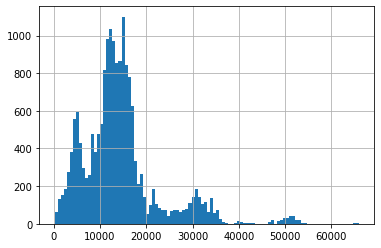

In [39]:
data['cityCenters_nearest'].hist(bins = 100);

Распределение нормальное.

##### Расстояние до ближайшего аэропорта.

<AxesSubplot:>

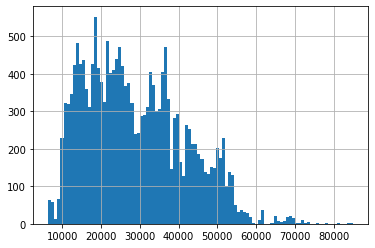

In [40]:
good_airports = data.query('airports_nearest !=0')
good_airports['airports_nearest'].hist(bins = 100);

Распределение нормальное. 

#####  Расстояние до ближайшего парка.

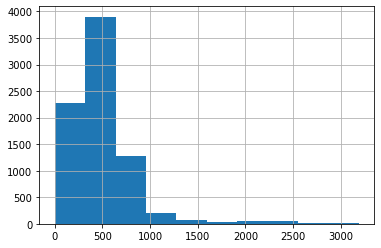

In [41]:
data['parks_nearest'].hist();

<div style="border:solid green 2px; padding: 20px">
В этом столбце было много пропусков, скорее всего парков поблизости данных объектов просто нет. Поэтому поле было незаполненно.

##### День и месяц публикации объявления.

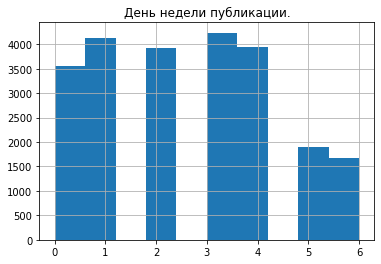

In [42]:
plt.title('День недели публикации.')
data['week_day'].hist();

2     2612
3     2558
11    2341
4     2335
10    2095
9     1955
6     1729
8     1728
7     1666
12    1618
1     1475
5     1249
Name: month, dtype: int64

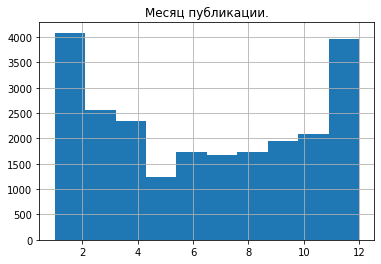

In [43]:
plt.title('Месяц публикации.')
data['month'].hist()
data['month'].value_counts().sort_values(ascending = False)

<div style="border:solid green 2px; padding: 20px">

1. В выходные реже продают(либо снимают с продажи) объекты недвижимости.

2. Пик продажи в феврале и марте, а май и декабрь с январём спад. Более вероятно связано с отпусками и праздниками.

#### Изучите, как быстро продавались квартиры.

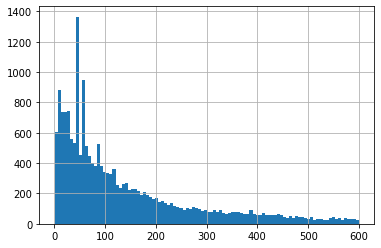

In [44]:
data['days_exposition'].hist(range = (1, 600), bins = 100);

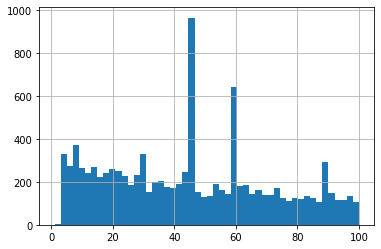

In [45]:
#Посмотрим на пики до 100 дней.
data['days_exposition'].value_counts().sort_values(ascending = False)
data['days_exposition'].hist(range = (1, 100), bins = 50);

<div style="border:solid green 2px; padding: 20px">
    
Этот столбец показывает, сколько дней было размещено каждое объявление. Поэтому я не могу ответить точно знать продалась ли квартира, или её сняли с публикации. Больше всего значений: 45, 60, 7, 30, 90 дней. На графике пик на 45 днях.

1. 30 дней - срок платного размещения на Яндекс Недвижимость.

2. 7 дней срок Премиум продвижения.

Пик в 45 дней объснить затруднительно, может раньше условия размещения были иными.

In [46]:
good_exposition = data.query('(days_exposition!=45)and (days_exposition!=0) and (days_exposition!=60)\
and (days_exposition!=7)and (days_exposition!=30) and (days_exposition!=90) and (days_exposition<600)')
good_exposition['days_exposition'].describe()

count    18079.000000
mean       143.495215
std        137.836524
min          1.000000
25%         44.000000
50%         93.000000
75%        202.000000
max        599.000000
Name: days_exposition, dtype: float64

 <div style="border:solid green 2px; padding: 20px">
    
Обычно продажа занимает от 44 до 202 дней. Ниже или выше этих значений можно считать очень быстрым, либо очень медленным вариантом.

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта.

In [47]:
data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'year', 'month', 'week_day']].corr()

,last_price,total_area,living_area,kitchen_area,rooms,year,month,week_day
last_price,1.000000,0.786608,0.693073,0.603553,0.520428,-0.036704,0.004982,-0.012481
total_area,0.786608,1.000000,0.934276,0.572623,0.789304,-0.073950,0.005326,-0.011578
living_area,0.693073,0.934276,1.000000,0.364705,0.874666,-0.066968,-0.004862,-0.008836
kitchen_area,0.603553,0.572623,0.364705,1.000000,0.224346,-0.051177,0.005218,-0.008904
rooms,0.520428,0.789304,0.874666,0.224346,1.000000,-0.048836,-0.003047,-0.004683
year,-0.036704,-0.073950,-0.066968,-0.051177,-0.048836,1.000000,-0.271947,-0.002673
month,0.004982,0.005326,-0.004862,0.005218,-0.003047,-0.271947,1.000000,0.012643
week_day,-0.012481,-0.011578,-0.008836,-0.008904,-0.004683,-0.002673,0.012643,1.000000


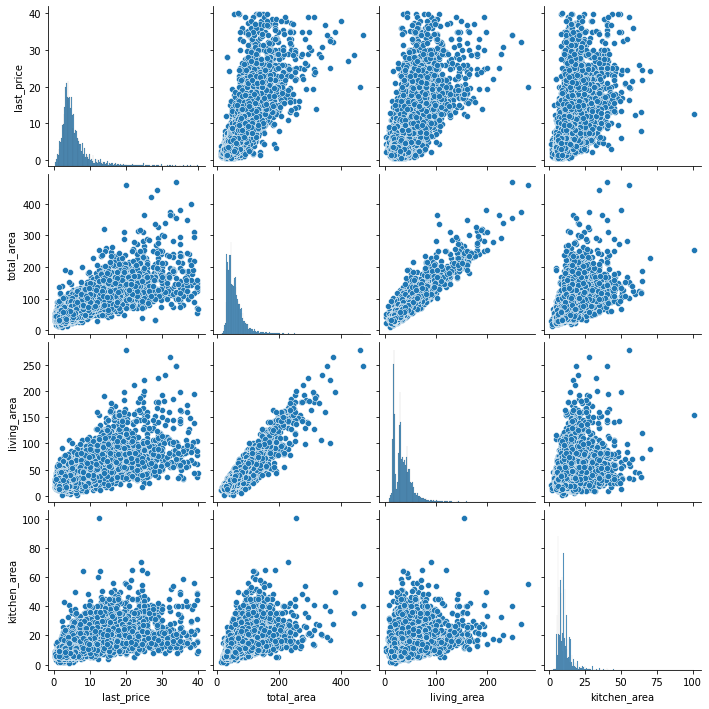

In [48]:
sns.pairplot(data[['last_price', 'total_area', 'living_area', 'kitchen_area']]);

<AxesSubplot:xlabel='rooms', ylabel='last_price'>

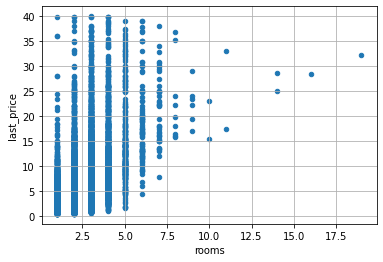

In [49]:
data.plot(x='rooms', y='last_price', grid=True, kind='scatter');

<AxesSubplot:xlabel='year'>

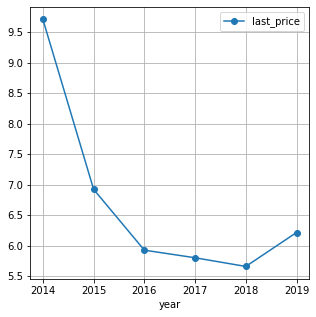

In [50]:
data.pivot_table(index='year', values='last_price').plot(grid=True, style='o-', figsize=(5, 5));

<AxesSubplot:xlabel='month'>

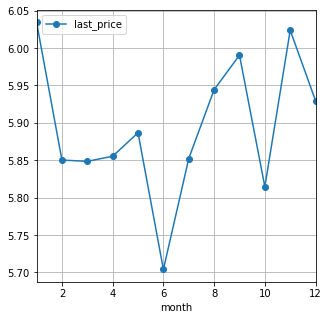

In [51]:
data.pivot_table(index='month', values='last_price').plot(grid=True, style='o-', xlim=(1,12), figsize=(5, 5));

<AxesSubplot:xlabel='week_day'>

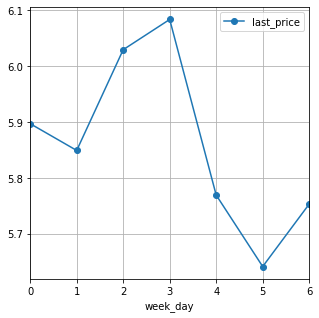

In [52]:
data.pivot_table(index='week_day', values='last_price').plot(grid=True, style='o-', xlim=(0,6), figsize=(5, 5));

##### Вывод.

<div style="border:solid green 2px; padding: 20px">
    
Исследовательский анализ данных позволил нам получить следующие выводы:

В Санкт-Петербурге присутствует много объектов недвижимости старого фонда, что может приводить к наличию нетипичных параметров, таких как большая общая площадь и более 10 комнат (коммунальные квартиры) или потолки более 3 метров (сталинские дома, пентхаусы и прочее).

Распределение общей площади объектов недвижимости нормальное, и большинство квартир имеют площадь от 40 до 69 квадратных метров.

Распределение жилой площади также нормальное, и большинство объектов имеют жилую площадь в диапазоне от 18.6 до 42 квадратных метров.

Распределение площади кухни также нормальное, и большинство объектов имеют площадь кухни от 7 до 12 квадратных метров.

Распределение цен на объекты недвижимости также близко к нормальному, и большинство объектов имеют цену от 3.4 миллионов до 6.7 миллионов.

Самая распространенная квартира имеет 1 или 2 комнаты.

Высота потолков в большинстве объектов находится в диапазоне от 2.6 до 2.7 метров.

Большинство объектов находятся на этажах от 2 до 8, и тип этажа чаще всего является "другим" (не первым и не последним).

Объявления, размещенные в выходные дни, реже приводят к продаже (или снимаются с продажи) объектов недвижимости.

Наблюдается пик продаж в феврале и марте, а в мае и декабре с январем наблюдается спад, что может быть связано с отпусками и праздниками.

Столбец "days_exposition," показывающий, сколько дней было размещено каждое объявление, имеет пик на 45 днях, что может быть связано с условиями размещения на платформе.

Обычно продажа объекта недвижимости занимает от 44 до 202 дней, и значения ниже или выше этого диапазона можно считать быстрыми или медленными продажами.

Эти выводы помогут нам лучше понять характеристики объектов недвижимости и особенности их продажи на рынке Санкт-Петербурга и ближайших районах.

#### Анализ средней стоимости одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

<AxesSubplot:xlabel='locality_name'>

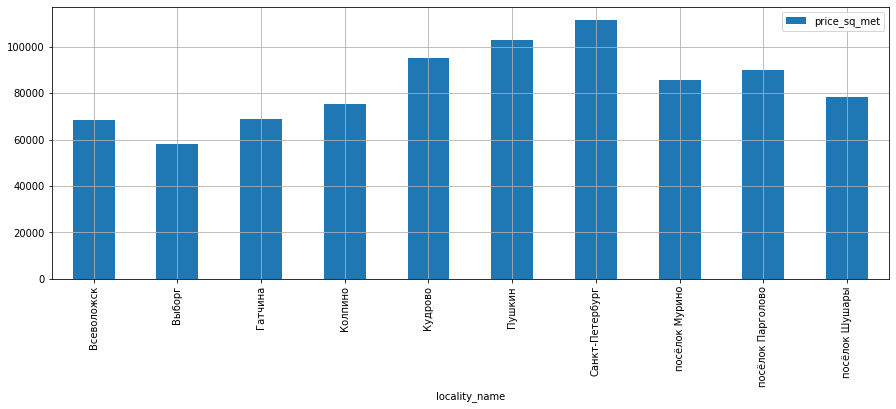

In [53]:
city_10 = data['locality_name'].value_counts().sort_values(ascending = False).head(10)
data.query('locality_name in @city_10.index').pivot_table(index = 'locality_name', values = 'price_sq_met')\
.plot(grid=True, kind = 'bar', figsize=(15, 5))

##### Вывод.

<div style="border:solid green 2px; padding: 20px">
    
Самые высокие цены ожидаемо в Санкт-Петербурге. Самые низкие цены в Гатчине.

#### Анализ средней стоимости по удаленности от центра объектов Санкт-Петербурга.

<AxesSubplot:xlabel='distance_downtown'>

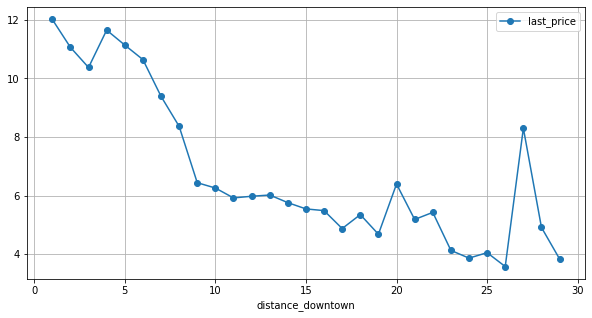

In [54]:
data.query('(locality_name == "Санкт-Петербург") and (distance_downtown !=0)')\
.pivot_table(index = 'distance_downtown', values = 'last_price').plot(grid=True, style='o-', figsize=(10, 5));


<div style="border:solid green 2px; padding: 20px">
    
Выделяется падение цены на 3 км от центра. Скорее всего это связана с большим количеством студий(в данном районе было много коммунальных квартир, которые позже переделали в квартиры-студии).

Учитывая выводы о том, что общая площадь влияет на конечную стоимость, посмотрим на график по сводной таблице.

<AxesSubplot:xlabel='distance_downtown'>

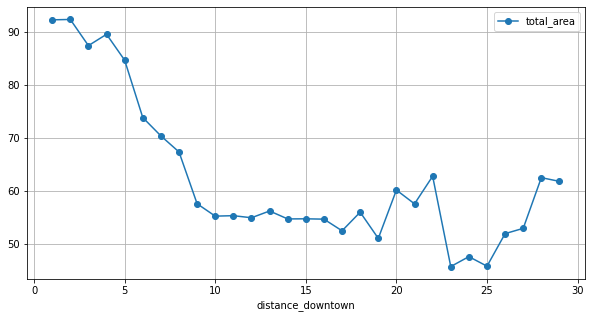

In [55]:
data.query('(locality_name == "Санкт-Петербург") and (distance_downtown !=0)')\
.pivot_table(index = 'distance_downtown', values = 'total_area').plot(grid=True, style='o-', figsize=(10, 5));


<div style="border:solid green 2px; padding: 20px">
Да, падение общей площади наблюдается на 3 км от центра. 

<div style="border:solid green 2px; padding: 20px">
Чем ближе к центру, тем цена выше. Судя по графику центр города ограничен 5 км. 
 
Дальше 17 км от центра влияние фактора расстояние от центра теряется.

### Общий вывод


<div style="border:solid green 2px; padding: 20px">

**Исследование отдельных параметров объектов.**
    
В Санкт-Петербурге присутствуют квартиры нетипичные для многих других городов: большая общая площадь и более 10 комнат(коммунальные квартиры), свыше 3 метров потолки ("сталинки", пентхаусы и прочее). Однако большинство квартир имеют диапазон параметров:
- `Общая площадь` от 40 до 69 кв.м.
- `Жилая площадь` от 18.6 до 42 кв.м.
- `Площадь кухни` в пределах от 7 до 12 кв.м. 
- `Цена` от 3,4 млн до 6,7 млн.
- `Количество комнат` 1 - 3.
- `Высота потолков` от 2,6 до 2,7 м.
- `Этаж` от 2 до 8.
- `Жилая площадь` от 18.6 до 42 кв.м.
- `Площадь кухни` в пределах от 7 до 12 кв.м. 
- `Цена` от 3,4 млн до 6,7 млн.   
- `Количество комнат` 1 - 3.
- `Высота потолков` от 2,6 до 2,7 м.
- `Этаж` от 2 до 8.
    
Объекты чаще всего располагаются в `5 и 9 этажных домах`. Последний пик 25 этажей. Это может быть связанно с тем, что:
- В советсткое время чаще строили 5 и 9 этажные здания. Постройки до пятого этажа не требуют установки лифта, свыше девяти этажей строения должны иметь два лифта и противопожарную лестницу.
- В Санкт-Петербурге и ближайших районах есть запрет на постройку высоких зданий в исторических районах и центре.
- Для зданий свыше 25 этажей требуется более строгое соблюдение пожарной безопасности(максимальная высота автолестницы пожарной до 25 этажей).

**Исследование длительности продажи объектов.**
    
При исследовании длительности продажи квартир, были исключены пиковые значения, связанные с особенностью функционирования системы размещения объявлений. Обычно продажа занимает `от 44 до 202 дней`. Ниже или выше этих значений можно считать очень быстрым, либо очень медленным вариантом. 

**Исследование факторов влияющих на общую (полную) стоимость объекта.**
    
- Больше всего на цену влияет общая и жилая площадь.  
- Квартиры опубликованные в 2014 году были выше в цене.
- Количество комнат влияет на цену, но меньше, чем общая площадь.
- В выходные реже продают (либо снимают с продажи) объекты недвижимости.
- Пик продажи в феврале и марте, а май и декабрь с январём спад. Более вероятно связано с отпусками и праздниками.
- Самая высокая цена квартир, опубликованных в декабре и четверг. Самые дешёвые в июне и в субботу.

**Исследование средней стоимости за квадратный метр в 10 населённых пунктах с наибольшим числом объявлений.**
    
Самые высокие цены ожидаемо в `Санкт-Петербурге`. Самые низкие цены в `Гатчине`.
    
**Исследование средней цены каждого километра в Санкт-Петербурге.**
    
- Выделяется `падение цены на 3 км от центра`. Именно в этой локации много объектов с малой общей площадью. 
- Центр ограничивается `5 км`. Чем ближе к этим параметрам, тем стоимость выше. Однако дальше 17 км зависимость от этого фактора меньше.